In [1]:
import re
import itertools
# import json
# import simplejson as json
import ujson as json
import pandas as pd


def read_jsl_fln(filename='im_metro_items.jsl'):
    return (json.loads(line.strip()) for line in open(filename))


def read_jsl(fobj):
    for line in fobj:
        line = line.strip()
        if not line:
            continue
        item = json.loads(line)
        yield item


def parse_number(value):
    if len(value) > 100:
        return None
    value = value.replace(',', '.').replace(' ', '').strip()
    if not re.search(r'^-?[0-9]+(?:\.[0-9]+)?$', value):
        return None
    return float(value)


def parse_price(item):
    value = item.get('price_text')
    if not value:
        return None
    if not value.endswith(' ₽'):
        return None
    return parse_number(value[:-2])


AMOUNT_MAP = {' кг': 1000, ' г': 1}


def parse_mass(value):
    if not value:
        return None
    for key, multiplier in AMOUNT_MAP.items():
        if value.endswith(key):
            value_pre = value
            value = parse_number(value[:-len(key)])
            if not value:
                continue
            value = value * multiplier
            return value
    return None


def parse_cals(item):
    value = item['nutrition_properties'].get('Калорийность')
    suffix = ' ккал'
    if not value or not value.endswith(suffix):
        return None
    return parse_number(value[:-len(suffix)])


with open('im_metro_items.jsl') as fobj:
    data = read_jsl(fobj)

    # data = itertools.islice(data, 100)

    # Legacy:
    data = (dict(
        item,
        nutrition_properties=item.get('nutrition_properties') or item.get('nutritipn_properties') or {},
    ) for item in data)

    data = (dict(
        # item,
        url=item['url'],
        title=item['title'],
        cat=item['crumbs'][-1]['title'],

        amount_text=item.get('amount_text'),
        price_text=item.get('price_text'),
        # nutrition_properties=item.get('nutrition_properties'),
        protein_text=item['nutrition_properties'].get('Белки'),
        carbs_text=item['nutrition_properties'].get('Углеводы'),
        cals_text=item['nutrition_properties'].get('Калорийность'),
        nutrition_title=item.get('nutrition_title'),

        price_rub=parse_price(item),
        protein_g=parse_mass(item['nutrition_properties'].get('Белки')),
        carbs_g=parse_mass(item['nutrition_properties'].get('Углеводы')),
        cals=parse_cals(item),
        amount_g=parse_mass(item.get('amount_text')),
    ) for item in data)

    data = list(data)

df = pd.DataFrame(data)
df_0 = df
print(len(df))
df.head()

19736


,amount_g,amount_text,cals,cals_text,carbs_g,carbs_text,cat,nutrition_title,price_rub,price_text,protein_g,protein_text,title,url
0,1000.0,1 кг,32.0,32 ккал,6.9,"6,9 г",Свежие овощи,None,29.99,"29,99 ₽",1.3,"1,3 г",Морковь Дмитровские овощи мытая,https://instamart.ru/metro/ioghurt-landliebe-p...
1,1000.0,1 кг,15.0,15 ккал,2.8,"2,8 г",Свежие овощи,None,39.89,"39,89 ₽",0.8,"0,8 г",Огурцы,https://instamart.ru/metro/oghurtsy-11
2,1000.0,1 кг,20.0,20 ккал,4.2,"4,2 г",Свежие овощи,None,62.90,"62,90 ₽",0.6,"0,6 г",Помидоры,https://instamart.ru/metro/tomaty-ghruntovyie
3,1000.0,1 кг,24.0,24 ккал,4.6,"4,6 г",Свежие овощи,None,44.69,"44,69 ₽",0.6,"0,6 г",Кабачки грунтовые,https://instamart.ru/metro/kabachki-ghruntovyie
4,450.0,450 г,15.0,15 ккал,2.8,"2,8 г",Свежие овощи,None,79.90,"79,90 ₽",0.8,"0,8 г",Огурцы короткоплодные Московский Люкс на подло...,https://instamart.ru/metro/oghurtsy-liuks-v-lo...


In [2]:
pd.set_option('display.max_colwidth', 1000)

In [3]:
df = df_0.copy()
df['rub_per_protein_g'] = df['price_rub'] / (df['protein_g'] / 100 * df['amount_g'])
df.sort_values('rub_per_protein_g', inplace=True)
df_1 = df
df.head(15)

,amount_g,amount_text,cals,cals_text,carbs_g,carbs_text,cat,nutrition_title,price_rub,price_text,protein_g,protein_text,title,url,rub_per_protein_g
3303,10000.0,10 кг,330.0,330 ккал,13.0,13 г,"Мука, дрожжи, добавки",None,178.00,"178,00 ₽",26.0,26 г,Мука пшеничная Horeca Select высший сорт,https://instamart.ru/metro/muka-pshienichnaia-horeca-select-vysshii-sort,0.068462
2657,900.0,900 г,350.0,350 ккал,62.0,62 г,Крупы,None,18.89,"18,89 ₽",23.0,23 г,Горох Каскад колотый,https://instamart.ru/metro/gorokh-kaskad-kolotyi,0.091256
15366,6000.0,6 кг,NaN,None,NaN,None,Корм для собак,None,151.00,"151,00 ₽",27.0,27 г,Корм Perfect Fit сухой для взрослых собак мелких и миниатюрных пород с курицей,https://instamart.ru/metro/korm-perfect-fit-sukhoi-dlia-vzroslykh-sobak-mielkikh-i-miniatiurnykh-porod-s-kuritsiei,0.093210
2656,900.0,900 г,330.0,330 ккал,57.0,57 г,Крупы,None,21.89,"21,89 ₽",22.0,22 г,Горох Каскад целый,https://instamart.ru/metro/gorokh-kaskad-tsielyi,0.110556
15363,6400.0,"6,4 кг",NaN,None,NaN,None,Корм для собак,None,257.00,"257,00 ₽",27.5,"27,5 г",Корм Perfect Fit сухой для щенков средних и крупных пород с курицей,https://instamart.ru/metro/korm-perfect-fit-sukhoi-dlia-shchienkov-sriednikh-i-krupnykh-porod-s-kuritsiei,0.146023
15364,6400.0,"6,4 кг",NaN,None,NaN,None,Корм для собак,None,248.00,"248,00 ₽",25.0,25 г,Корм Perfect Fit сухой для взрослых собак от 1 года средних и крупных пород с курицей,https://instamart.ru/metro/korm-perfect-fit-sukhoi-dlia-vzroslykh-sobak-sriednikh-i-krupnykh-porod-s-kuritsiei,0.155000
2649,900.0,900 г,350.0,350 ккал,68.0,68 г,Крупы,None,18.99,"18,99 ₽",13.0,13 г,Крупа гречневая Каскад Греча ядрица быстроразваривающаяся,https://instamart.ru/metro/krupa-grechnevaya-kaskad-grecha-yadritsa-bystrorazvarivayuschayasya,0.162308
3393,2000.0,2 кг,334.0,334 ккал,70.6,"70,6 г","Мука, дрожжи, добавки",None,39.99,"39,99 ₽",10.3,"10,3 г",Мука Лимак Подгоренская пшеничная хлебопекарная высшего сорта,https://instamart.ru/metro/muka-limak-podghorienskaia-pshienichnaia-khliebopiekarnaia-vysshiegho-sorta,0.194126
11085,525.0,525 г,349.0,349 ккал,NaN,None,Мясные консервы,None,137.01,"137,01 ₽",133.0,"133,0 г",Свинина Главпродукт тушеная ГОСТ,https://instamart.ru/metro/svinina-tushiennaia-glavprodukt-gost,0.196219
2652,900.0,900 г,300.0,300 ккал,54.0,54 г,Крупы,None,49.49,"49,49 ₽",23.0,23 г,Горох Шебекинский среднерусский,https://instamart.ru/metro/gorokh-shiebiekinskii-sriednierusskii-1,0.239082


In [4]:
df = df_1.copy()
df['cals_per_protein_g'] = df['cals'] / df['protein_g']
df['q'] = df['rub_per_protein_g'] * df['cals']  # (rub * cals) / protein_g
df['rub_per_kg'] = df['price_rub'] / df['amount_g'] * 1000
df = df[~ df['rub_per_protein_g'].isnull()]
# df.sort_values('q', inplace=True)
df.sort_values('cals_per_protein_g', inplace=True)
prio = ['q', 'protein_g', 'cals', 'rub_per_protein_g', 'cals_per_protein_g', 'price_rub', 'amount_g', 'rub_per_kg', 'cat', 'title', 'url']
df = df[prio + [col for col in df.columns if col not in prio]]
df.head(50)

,q,protein_g,cals,rub_per_protein_g,cals_per_protein_g,price_rub,amount_g,rub_per_kg,cat,title,url,amount_text,cals_text,carbs_g,carbs_text,nutrition_title,price_text,protein_text
9511,5.433383,18.0,2.0,2.716691,0.111111,1100.26,2250.0,489.004444,Морепродукты,Щупальца кальмара Фландерр охлажденные,https://instamart.ru/metro/shchupaltsa-kalmara-flandierr-okhlazhdiennyie-2-2-5-kgh,"2,25 кг",2 ккал,NaN,None,None,"1 100,26 ₽","18,0 г"
299,3.852222,2.7,0.4,9.630556,0.148148,104.01,400.0,260.025000,Грибы,Грибы шампиньоны Hortex резаные,https://instamart.ru/metro/shampinony-hortex-riezanyie,400 г,"0,4 ккал",0.6,"0,6 г",None,"104,01 ₽","2,7 г"
10859,72.637727,11.0,3.7,19.631818,0.336364,43.19,20.0,2159.500000,Специи и пряности,Перец fine life черный молотый,https://instamart.ru/metro/pieriets-fine-life-chiernyi-molotyi-1,20 г,"3,7 ккал",52.5,"52,5 г",None,"43,19 ₽",11 г
8365,12.202150,10.1,3.7,3.297878,0.366337,58.29,175.0,333.085714,Мясные деликатесы,Паштет Mortier охотничий,https://instamart.ru/metro/pashtiet-mortier-okhotnichii,175 г,"3,7 ккал",3.6,"3,6 г",None,"58,29 ₽","10,1 г"
513,11.492163,17.0,20.6,0.557872,1.211765,64.49,680.0,94.838235,Овощные консервы,Ассорти Fine Life из корнишонов и черри,https://instamart.ru/metro/assorti-kornishonov-i-chierri-fine-life,680 г,"20,6 ккал",3.7,"3,7 г",None,"64,49 ₽","17,0 г"
8544,26.001587,10.5,15.0,1.733439,1.428571,163.81,900.0,182.011111,"Сосиски, сардельки",Сардельки Черкизово Сытные,https://instamart.ru/metro/sardielki-chierkizovskii-sytnyie,900 г,15 ккал,2.0,2 г,None,"163,81 ₽","10,5 г"
19567,142.028986,23.0,35.0,4.057971,1.521739,224.00,240.0,933.333333,Сыры твердые и полутвердые,Сыр Тысяча озер Kova 45%,https://instamart.ru/metro/syr-tysiacha-ozier-kova-45-percent,240 г,35 ккал,NaN,None,None,"224,00 ₽","23,0 г"
10264,135.800000,5.0,9.7,14.000000,1.940000,105.00,150.0,700.000000,Соусы и кетчуп,Соус соевый Pearl River Bridge Слабосоленый,https://instamart.ru/metro/sous-soievyi-pearl-river-bridge-slabosolienyi,150 г,"9,7 ккал",4.5,"4,5 г",None,"105,00 ₽",5 г
4482,524.800000,0.5,1.0,524.800000,2.000000,65.60,25.0,2624.000000,Чай,Чай черный Lipton Yellow label в пакетиках,https://instamart.ru/metro/chai-chiernyi-lipton-yellow-label-v-pakietikakh,25 г,1 ккал,NaN,None,None,"65,60 ₽","0,5 г"
11053,144.477665,133.0,349.0,0.413976,2.624060,234.00,425.0,550.588235,Мясные консервы,Свинина Глапродукт тушеная ГОСТ,https://instamart.ru/metro/svinina-tushienaia-glavprodukt,425 г,349 ккал,NaN,None,None,"234,00 ₽","133,0 г"


In [44]:
import altair as alt
alt.data_transformers.enable('json')

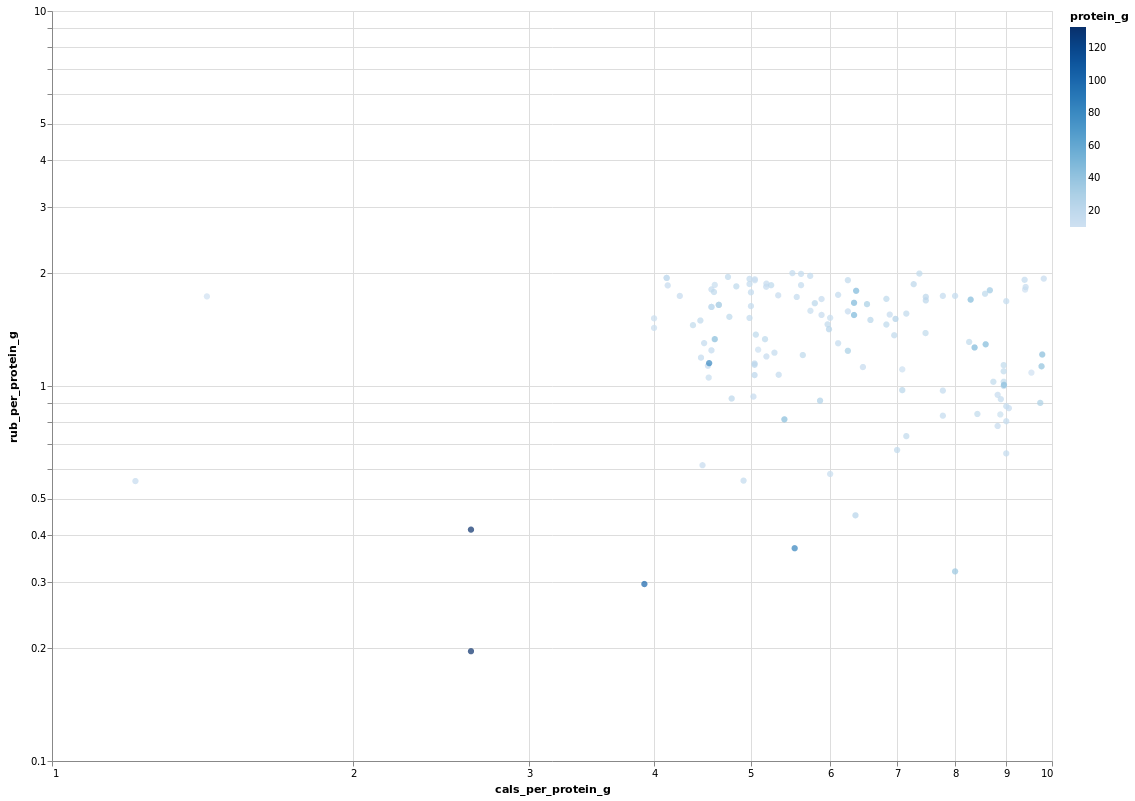

In [161]:
col1 = 'cals_per_protein_g'
col2 = 'rub_per_protein_g'
# click = alt.selection_multi(encodings=['color'])
sel1 = alt.selection_single(
    on='mouseover',
    # on='click',
    nearest=True,
    # encodings=['color'],
)
sel2 = alt.selection_single(
    on='click',
    nearest=True,
)

(alt
 .Chart(df[~(df[col1].isnull() | df[col2].isnull()) & (df['cals_per_protein_g'] < 10) & (df['rub_per_protein_g'] < 2)])
 .properties(
     width=1000, height=750,
     # selection=alt.selection_single(nearest=True),
 )
 .mark_circle(
     # size=20,
     size=40,
 )
 # .configure_view(clip=True)
 .interactive()
 # .add_selection(sel1)
 .encode(
     alt.X(
         col1 + ':Q',
         scale=alt.Scale(
             type='log',
             # type='pow', exponent=0.1,
             # domain=(0.1, 100),
             # zero=False,
         ),
     ),
     alt.Y(
         col2 + ':Q',
         scale=alt.Scale(
             type='log',
             # type='pow', exponent=0.1,
             # domain=(0.05, 150),
             # zero=False,
         ),
     ),
     color='protein_g:Q',
     # color=alt.condition(sel1, alt.value('blue'), alt.value('lightgray')),
     tooltip=['title', 'protein_g', col1, col2],
     href='url',
#      tooltip=list(
#          alt.Tooltip(
#              col,
#              # condition=alt.condition(sel1, alt.value('1'), alt.value('0')),
#          ) for col in ('title', 'url', col1, col2)),
))

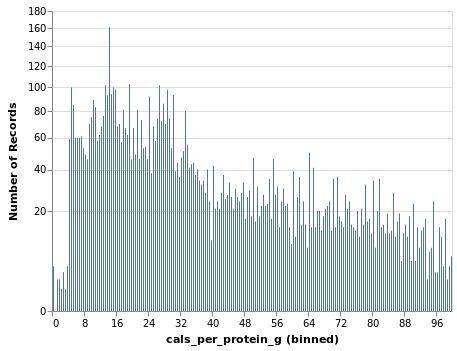

In [47]:
col = 'cals_per_protein_g'
alt.Chart(df[df[col] < 100]).mark_bar().encode(
    alt.X(col,
          bin=alt.BinParams(maxbins=200),
          scale=alt.Scale(type='pow', exponent=0.5)),
    alt.Y('count()',
          scale=alt.Scale(type='pow', exponent=0.5)),
)